In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import os, glob
import json
import pandas as pd

In [37]:
def process_json(filename):
    df = pd.DataFrame(columns=['content', 'lang'])
    min_chars, max_chars = 160, 1200
    max_header_size = 700

    line = -1
    ln, count = 0, 0
    with open(filename) as fp:
        while line:
            line = fp.readline()
            ln += 1
            if len(line) > max_chars+max_header_size:
                continue

            if   '"subreddit":"ru"' in line \
              or '"subreddit":"russian"' in line \
              or '"subreddit":"Popular_Science_Ru"' in line \
              or '"subreddit":"liberta"' in line \
              or '"subreddit":"RussNews"' in line \
              or '"subreddit":"politota"' in line:
                lang = 'ru'
            elif '"subreddit":"pt"' in line \
              or '"subreddit":"portugues"' in line \
              or '"subreddit":"brasil"' in line \
              or '"subreddit":"brazil"' in line:
                lang = 'pt'
            elif '"subreddit":"france"' in line \
              or '"subreddit":"francais"' in line \
              or '"subreddit":"French"' in line:
                lang = 'fr'
            elif '"subreddit":"es"' in line \
              or '"subreddit":"espanol"' in line \
              or '"subreddit":"spain"' in line \
              or '"subreddit":"mexico"' in line:
                lang = 'es'
            elif '"subreddit":"italy"' in line \
              or '"subreddit":"italia"' in line:
                lang = 'it'
            elif '"subreddit":"KGBTR"' in line \
              or '"subreddit":"Turkey"' in line:
                lang = 'tr'
            else:
                continue

            # print("Line {}: {}".format(ln, line.strip()))
            data = json.loads(line)
            body = data['body']
            # print(len(body)-len(line), len(body), len(line))
            if max_chars > len(body) > min_chars:
                # print(f"Line {count}/{ln}: {body}")
                df.loc[count] = [body, lang]
                # print(df.tail())
                count += 1
                # print(json.dumps(data, indent=4, sort_keys=True))
                # if count > 10:
                #   break

    print(filename, count, ln)
    return df

In [38]:
!ls ../input/reddit
filename = '../input/reddit/RC_2014-04'

RC_2011-04  RC_2015-02	RC_2015-05  RC_2017-08	RC_2018-03
RC_2014-04  RC_2015-03	RC_2017-06  RC_2017-09
RC_2014-05  RC_2015-04	RC_2017-07  RC_2018-02


In [39]:
# %%time
# df = process_json(filename)
# df.groupby('lang').content.count().to_frame('count').T

In [53]:
# !rm ../*.parquet.gzip

for filename in glob.glob(f'../input/reddit/RC*'):
    try:
        if not glob.glob(f'../{os.path.basename(filename)}_*.parquet.gzip'):
            df = process_json(filename)
            df.to_parquet(f'../{os.path.basename(filename)}_{len(df)}.parquet.gzip',
                            compression='gzip', index=False)
    except Exception as ex:
        print(ex)

!ls -sh ../*.parquet.gzip

../input/reddit/RC_2015-06 44466 54258493
../input/reddit/RC_2017-10 112029 85828913
312K ../RC_2011-04_1723.parquet.gzip    19M ../RC_2017-06_107852.parquet.gzip
2,4M ../RC_2014-04_13734.parquet.gzip   19M ../RC_2017-07_104343.parquet.gzip
2,9M ../RC_2014-05_16396.parquet.gzip   19M ../RC_2017-08_103863.parquet.gzip
5,7M ../RC_2015-02_32863.parquet.gzip   19M ../RC_2017-09_109034.parquet.gzip
6,7M ../RC_2015-03_38587.parquet.gzip   20M ../RC_2017-10_112029.parquet.gzip
6,7M ../RC_2015-04_38570.parquet.gzip   19M ../RC_2018-02_105310.parquet.gzip
6,9M ../RC_2015-05_39788.parquet.gzip   17M ../RC_2018-03_103558.parquet.gzip
7,8M ../RC_2015-06_44466.parquet.gzip


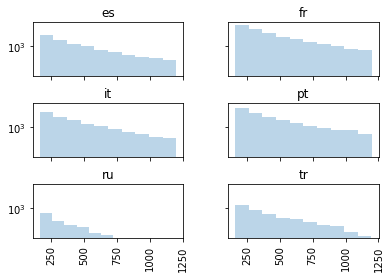

In [54]:
df['len'] = df.content.str.len()
# df['len'].hist(bins=10, log=True)
# plt.show()

# from matplotlib import pyplot as plt
# fig, ax = plt.subplots(1)
# _ = df.groupby('lang')['len'].hist(bins=10, log=True, alpha=0.3, ax=ax)
# _ = plt.legend(df.lang.unique())
df.hist(column='len', by='lang', bins=10, log=True, alpha=0.3, sharex=True, sharey=True)
del df['len']

In [71]:
df = None
for path in sorted(glob.glob(f'../*.parquet.gzip')):
    counts = pd.read_parquet(path).groupby('lang').content.count().to_frame('count').T
    print(counts, path)
    if df is None:
        df = counts
    else:
        df = df.append(counts, ignore_index=True)

df.sum(axis=0).T.sort_values().astype(int).to_frame('count')

lang     es   fr  it  ru  tr
count  1215  411  75  20   2 ../RC_2011-04_1723.parquet.gzip
lang     es    fr    it    pt   ru   tr
count  2502  5163  3680  1077  351  961 ../RC_2014-04_13734.parquet.gzip
lang     es    fr    it    pt   ru    tr
count  3223  5536  4718  1486  413  1020 ../RC_2014-05_16396.parquet.gzip
lang     es     fr    it    pt   ru    tr
count  2693  12330  9169  7176  488  1007 ../RC_2015-02_32863.parquet.gzip
lang     es     fr    it     pt   ru    tr
count  3461  14731  8223  10358  611  1203 ../RC_2015-03_38587.parquet.gzip
lang     es     fr    it    pt   ru    tr
count  3329  16259  8821  7337  579  2245 ../RC_2015-04_38570.parquet.gzip
lang     es     fr    it    pt   ru    tr
count  3474  15531  9912  8065  502  2304 ../RC_2015-05_39788.parquet.gzip
lang     es     fr     it    pt   ru    tr
count  4237  18577  10325  7943  724  2660 ../RC_2015-06_44466.parquet.gzip
lang      es     fr     it     pt    ru    tr
count  11384  49705  18891  22410  1388  4074 .

,count
lang,
ru,12452
tr,40975
es,103436
it,197787
pt,230612
fr,386854


In [46]:
# import pdb; pdb.pm()